# Intraday Strategy, Part 2: Model Training & Signal Evaluation

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and use the features engineered in the last notebook to train gradient boosting model that predicts the returns for the NASDAQ100 stocks over the next 1-minute bar. 

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact. This does certainly not reflect market reality, and is rather due to the challenges of simulating a trading strategy at this much higher intraday frequency in a realistic manner using open-source tools.

Note also that this section has slightly changed from the version published in the book to permit replication using the Algoseek data sample.

In [1]:
# %sudo apt install cmake
# %pip install lightgbm --config-setting=cmake.define.USE_CUDA=ON 
# %pip install tables

In [2]:
# https://docs.cupy.dev/en/stable/install.html#installing-cupy
# %pip install --extra-index-url https://pypi.nvidia.com cupy-cuda12x cudf-cu12 "dask[complete]"

In [3]:
# %load_ext cython

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43581")
client

In [2]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
# client = Client.current()
# client = Client()
# client

# client = Client(n_workers=1, 
#                 threads_per_worker=1,
#                 memory_limit='70GB')
client

<Client: 'tcp://127.0.0.1:39319' processes=4 threads=16, memory=78.38 GiB>

In [ ]:
print(client.cluster)

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
lgb.sklearn.SKLEARN_INSTALLED

True

In [4]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [6]:
# where we stored the features engineered in the previous notebook
data_store = '../data/nasdaq100/algoseek-longer.h5'

In [7]:
# where we'll store the model results
result_store = 'results/longer-intraday.h5'

In [8]:
# here we save the trained models
model_path = Path('models/longer-intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

## Load Model Data

In [9]:
data = pd.read_hdf(data_store, 'model_data')

In [10]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 23 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   minute          13452358 non-null  int64  
 1   ret1min         13350557 non-null  float64
 2   ret2min         13180747 non-null  float64
 3   ret3min         13102981 non-null  float64
 4   ret4min         13025556 non-null  float64
 5   ret5min         12949249 non-null  float64
 6   ret6min         12871879 non-null  float64
 7   ret7min         12793437 non-null  float64
 8   ret8min         12715802 non-null  float64
 9   ret9min         12638377 non-null  float64
 10  ret10min        12560968 non-null  float64
 11  retwin          12560968 non-null  float64
 12  fwdwin          13452358 non-null  float64
 13  rup             13139376 non-null  float64
 14  rdown           13139376 non-null  flo

In [11]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,...,rup,rdown,BOP,CCI,MFI,STOCHRSI,slowd,slowk,NATR,trades_bid_ask
count,1.345236e+06,1.335084e+06,1.318219e+06,1.310338e+06,1.302669e+06,1.295118e+06,1.287209e+06,1.279418e+06,1.271554e+06,1.264095e+06,...,1.313790e+06,1.313790e+06,1.335084e+06,1.248749e+06,1.345061e+06,1.344845e+06,1.345018e+06,1.345018e+06,1.345061e+06,1.313790e+06
mean,8.480629e+01,-5.010883e-06,-5.355669e-06,-5.414775e-06,-7.397641e-06,-9.219782e-06,-8.250059e-06,-7.981108e-06,-7.772123e-06,-8.779579e-06,...,4.881222e-01,5.039298e-01,-3.126318e-03,-4.583143e-02,4.994269e+01,4.985147e+01,5.017732e+01,5.016522e+01,1.248300e-01,-4.457673e-02
std,4.929463e+01,1.082153e-03,1.454458e-03,1.745213e-03,1.969874e-03,2.170709e-03,2.351701e-03,2.530326e-03,2.682091e-03,2.813126e-03,...,1.214435e+01,1.794553e+01,6.265771e-01,1.099661e+02,2.000001e+01,3.561295e+01,2.797739e+01,2.883137e+01,9.487323e-02,1.719750e+01
min,0.000000e+00,-1.244796e-01,-1.237209e-01,-1.172914e-01,-1.354293e-01,-1.511628e-01,-1.774648e-01,-2.016041e-01,-2.180095e-01,-1.165179e-01,...,0.000000e+00,0.000000e+00,-1.000000e+00,-4.666667e+02,-4.948145e-10,0.000000e+00,-3.129941e-12,-3.349025e-12,3.236967e-03,-1.170100e+04
10%,1.700000e+01,-9.615385e-04,-1.345754e-03,-1.640958e-03,-1.886963e-03,-2.100411e-03,-2.289438e-03,-2.467105e-03,-2.622378e-03,-2.778618e-03,...,0.000000e+00,0.000000e+00,-8.888889e-01,-1.371837e+02,2.342854e+01,0.000000e+00,1.212121e+01,1.095181e+01,5.261034e-02,-6.923077e-01
20%,3.400000e+01,-5.310674e-04,-7.665467e-04,-9.417146e-04,-1.082251e-03,-1.205788e-03,-1.310616e-03,-1.412429e-03,-1.507182e-03,-1.598150e-03,...,1.018071e-01,1.084125e-01,-6.666667e-01,-9.965282e+01,3.189461e+01,9.390631e+00,2.041365e+01,1.944444e+01,6.463810e-02,-4.351344e-01
30%,5.100000e+01,-2.989090e-04,-4.359198e-04,-5.379236e-04,-6.227827e-04,-6.952031e-04,-7.584376e-04,-8.155773e-04,-8.719916e-04,-9.233610e-04,...,1.962504e-01,2.042110e-01,-4.500000e-01,-6.944486e+01,3.845958e+01,2.314056e+01,2.961288e+01,2.888889e+01,7.592931e-02,-2.653333e-01
40%,6.800000e+01,-1.293828e-04,-1.994117e-04,-2.467633e-04,-2.870985e-04,-3.210155e-04,-3.475239e-04,-3.723701e-04,-3.976934e-04,-4.219409e-04,...,2.779181e-01,2.882562e-01,-2.000000e-01,-3.760007e+01,4.430651e+01,3.644104e+01,3.959982e+01,3.921569e+01,8.787966e-02,-1.274497e-01
50%,8.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.561914e-01,3.671971e-01,0.000000e+00,9.993353e-02,4.985889e+01,4.975637e+01,5.015951e+01,5.000000e+01,1.015174e-01,-2.732021e-03
60%,1.020000e+02,1.226912e-04,1.881114e-04,2.318876e-04,2.655682e-04,2.974125e-04,3.267074e-04,3.506926e-04,3.731065e-04,3.982702e-04,...,4.378597e-01,4.486352e-01,1.904762e-01,3.765173e+01,5.544049e+01,6.313016e+01,6.081836e+01,6.111111e+01,1.180147e-01,9.096244e-02


## Model Training

### Helper functions

In [12]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Categorical Variables

In [13]:
data['stock_id'], ticker_to_id = pd.factorize(data.index.get_level_values('ticker'), sort=True)
ticker_to_id

Index(['AAL', 'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'ALGN', 'ALTR',
       'ALXN',
       ...
       'VRSK', 'VRTX', 'WBA', 'WDAY', 'WDC', 'WFM', 'WYNN', 'XLNX', 'XRAY',
       'YHOO'],
      dtype='object', length=142)

In [14]:
ticker_to_id[3]

'ADI'

In [15]:
categoricals = ['stock_id']

In [16]:
data['stock_id']

ticker  date_time          
AAL     2015-01-02 09:30:00      0
        2015-01-02 09:31:00      0
        2015-01-02 09:32:00      0
        2015-01-02 09:33:00      0
        2015-01-02 09:34:00      0
                              ... 
YHOO    2017-06-16 12:16:00    141
        2017-06-16 12:17:00    141
        2017-06-16 12:18:00    141
        2017-06-16 12:19:00    141
        2017-06-16 12:20:00    141
Name: stock_id, Length: 13452358, dtype: int64

### Custom Metric

In [17]:
import cupy

cupy.show_config()

cupy.cuda.get_device_id()

OS                           : Linux-6.8.0-51-generic-x86_64-with-glibc2.35
Python Version               : 3.11.10
CuPy Version                 : 13.3.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.26.4
SciPy Version                : 1.14.1
Cython Build Version         : 0.29.36
Cython Runtime Version       : 3.0.11
CUDA Root                    : /opt/conda/
nvcc PATH                    : /opt/conda/bin/nvcc
CUDA Build Version           : 12060
CUDA Driver Version          : 12070
CUDA Runtime Version         : 12060 (linked to CuPy) / 12050 (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Version                : 11203
cuRAND Version               : 10306
cuSOLVER Version             : (11, 6, 3)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 5)
Thrust Version               : 200600
CUB Build Version            : 200600
Jitify Build Version         : <unknown>
cuDNN Bui

0

In [18]:
# We really only care about picking the top k stocks rather than ranking the whole list of predicted returns.  
# But a feature we get from ranking the list is the low confidence when there are relative few distinct values.

In [19]:
import cudf


def spearmanr(preds: np.ndarray, labels: np.ndarray):
    """Custom IC eval metric for lightgbm"""
    t_preds = cudf.Series(preds)
    t_labels = cudf.Series(labels)
    return t_preds.corr(t_labels)


def ic_lgbm(preds: np.ndarray, train_data: np.ndarray):
    """Custom IC eval metric for lightgbm"""
    return 'ic', spearmanr(preds, train_data.get_label()), True # is_higher_better

In [20]:
# n_preds = np.array(list(range(1.0, 11.0)))
# n_labels = np.array(list(range(1.0, 11.0)))
n_preds = np.arange(11.0)
n_labels = lgb.Dataset(data=np.arange(11.0), label=np.arange(11.0))
ic_lgbm(n_preds, n_labels)

('ic', 1.0, True)

### Cross-validation setup

In [22]:
data

minute   ret1min   ret2min   ret3min   ret4min  \
ticker date_time                                                             
AAL    2015-01-02 09:30:00       0  0.004241       NaN       NaN       NaN   
       2015-01-02 09:31:00       1 -0.007896 -0.003688       NaN       NaN   
       2015-01-02 09:32:00       2  0.005552 -0.002387  0.001844       NaN   
       2015-01-02 09:33:00       3 -0.006072 -0.000185 -0.008079 -0.003872   
       2015-01-02 09:34:00       4  0.007773  0.001840  0.007773 -0.000184   
...                            ...       ...       ...       ...       ...   
YHOO   2017-06-16 12:16:00     166 -0.000191  0.000000 -0.000191 -0.000955   
       2017-06-16 12:17:00     167  0.000000 -0.000191  0.000000 -0.000191   
       2017-06-16 12:18:00     168 -0.000189 -0.000381 -0.000572 -0.000381   
       2017-06-16 12:19:00     169 -0.000765 -0.000861 -0.001052 -0.001243   
       2017-06-16 12:20:00     170 -0.000574 -0.001052 -0.001148 -0.001339   

                             ret5min   ret6min   ret7min   ret8min   ret9min  \
ticker date_time                                                               
AAL    2015-01-02 09:30:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:31:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:32:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:33:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:34:00  0.004057       NaN       NaN       NaN       NaN   
...                              ...       ...       ...       ...       ...   
YHOO   2017-06-16 12:16:00 -0.000382 -0.000287 -0.000765  0.000383  0.001339   
       2017-06-16 12:17:00 -0.000955 -0.000382 -0.000287 -0.000765  0.000383   
       2017-06-16 12:18:00 -0.000572 -0.001336 -0.000763 -0.000667 -0.001145   
       2017-06-16 12:19:00 -0.001052 -0.001243 -0.002006 -0.001434 -0.001339   
       2017-06-16 12:20:00 -0.001530 -0.001339 -0.001530 -0.002293 -0.001721   

                            ...     rdown       BOP         CCI        MFI  \
ticker date_time            ...                                              
AAL    2015-01-02 09:30:00  ...  0.088409  0.522727         NaN        NaN   
       2015-01-02 09:31:00  ...  0.605885 -0.860000         NaN        NaN   
       2015-01-02 09:32:00  ...  0.248803  0.857143         NaN        NaN   
       2015-01-02 09:33:00  ...  0.515424 -0.942857         NaN        NaN   
       2015-01-02 09:34:00  ...  0.107958  0.954545         NaN        NaN   
...                         ...       ...       ...         ...        ...   
YHOO   2017-06-16 12:16:00  ...  0.538025 -0.400000   21.294270  47.893392   
       2017-06-16 12:17:00  ...  0.533146  0.000000   20.159449  45.607851   
       2017-06-16 12:18:00  ...  0.297138 -0.495000   -6.129079  46.794833   
       2017-06-16 12:19:00  ...  0.662231 -0.800000  -73.104392  44.782144   
       2017-06-16 12:20:00  ...  0.947009 -0.750000 -139.704904  47.583519   

                             STOCHRSI      slowd      slowk      NATR  \
ticker date_time                                                        
AAL    2015-01-02 09:30:00        NaN        NaN        NaN       NaN   
       2015-01-02 09:31:00        NaN        NaN        NaN       NaN   
       2015-01-02 09:32:00        NaN        NaN        NaN       NaN   
       2015-01-02 09:33:00        NaN        NaN        NaN       NaN   
       2015-01-02 09:34:00        NaN        NaN        NaN       NaN   
...                               ...        ...        ...       ...   
YHOO   2017-06-16 12:16:00  64.340973  81.587302  77.142857  0.084162   
       2017-06-16 12:17:00  64.340973  77.777778  75.238095  0.083615   
       2017-06-16 12:18:00  49.906199  73.339683  67.638095  0.080406   
       2017-06-16 12:19:00  26.633135  66.679365  57.161905  0.081551   
       2017-06-16 12:20:00   0.000000  55.985434  43.156303  0.081220   

       

In [23]:
data.index.levels

FrozenList([['AAL', 'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'ALGN', 'ALTR', 'ALXN', 'AMAT', 'AMGN', 'AMZN', 'ASML', 'ATVI', 'AVGO', 'BATRA', 'BATRK', 'BBBY', 'BIDU', 'BIIB', 'BMRN', 'BRCM', 'CA', 'CDNS', 'CELG', 'CERN', 'CHKP', 'CHRW', 'CHTR', 'CMCSA', 'CMCSK', 'COST', 'CSCO', 'CSX', 'CTAS', 'CTRP', 'CTRX', 'CTSH', 'CTXS', 'DISCA', 'DISCK', 'DISH', 'DLTR', 'DTV', 'EA', 'EBAY', 'ENDP', 'EQIX', 'ESRX', 'EXPD', 'EXPE', 'FAST', 'FB', 'FISV', 'FOX', 'FOXA', 'GILD', 'GMCR', 'GOOG', 'GOOGL', 'GRMN', 'HAS', 'HOLX', 'HSIC', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JBHT', 'JD', 'KHC', 'KLAC', 'KRFT', 'LBTYA', 'LBTYK', 'LILA', 'LILAK', 'LLTC', 'LMCA', 'LMCK', 'LRCX', 'LVNTA', 'MAR', 'MAT', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MSFT', 'MU', 'MXIM', 'MYL', 'NCLH', 'NFLX', 'NTAP', 'NTES', 'NVDA', ...], [2015-01-02 09:30:00, 2015-01-02 09:31:00, 2015-01-02 09:32:00, 2015-01-02 09:33:00, 2015-01-02 09:34:00, 2015-01-02 09:35:00, 2015-01-02 09:36:00, 2015-01-02 09:37:00, 2015-01-02 09:38:00, 2

In [24]:
data.index.get_level_values(1)

DatetimeIndex(['2015-01-02 09:30:00', '2015-01-02 09:31:00',
               '2015-01-02 09:32:00', '2015-01-02 09:33:00',
               '2015-01-02 09:34:00', '2015-01-02 09:35:00',
               '2015-01-02 09:36:00', '2015-01-02 09:37:00',
               '2015-01-02 09:38:00', '2015-01-02 09:39:00',
               ...
               '2017-06-16 12:11:00', '2017-06-16 12:12:00',
               '2017-06-16 12:13:00', '2017-06-16 12:14:00',
               '2017-06-16 12:15:00', '2017-06-16 12:16:00',
               '2017-06-16 12:17:00', '2017-06-16 12:18:00',
               '2017-06-16 12:19:00', '2017-06-16 12:20:00'],
              dtype='datetime64[ns]', name='date_time', length=13452358, freq=None)

In [25]:
data.index.get_level_values(1).min().date(), data.index.get_level_values(1).max().date()

(datetime.date(2015, 1, 2), datetime.date(2017, 12, 29))

In [26]:
data.index.get_level_values(1)[data.index.get_level_values(1).date == data.index.get_level_values(1).min().date()]

DatetimeIndex(['2015-01-02 09:30:00', '2015-01-02 09:31:00',
               '2015-01-02 09:32:00', '2015-01-02 09:33:00',
               '2015-01-02 09:34:00', '2015-01-02 09:35:00',
               '2015-01-02 09:36:00', '2015-01-02 09:37:00',
               '2015-01-02 09:38:00', '2015-01-02 09:39:00',
               ...
               '2015-01-02 12:11:00', '2015-01-02 12:12:00',
               '2015-01-02 12:13:00', '2015-01-02 12:14:00',
               '2015-01-02 12:15:00', '2015-01-02 12:16:00',
               '2015-01-02 12:17:00', '2015-01-02 12:18:00',
               '2015-01-02 12:19:00', '2015-01-02 12:20:00'],
              dtype='datetime64[ns]', name='date_time', length=17691, freq=None)

In [27]:
data_by_date = data.reorder_levels(["date_time", "ticker"])
data_by_date.sort_index(inplace=True)

In [28]:
from datetime import datetime, timedelta


In [29]:
date_time_values = data_by_date.index.get_level_values('date_time')
data_dates = np.unique(date_time_values.date)
data_date_times = sorted(pd.to_datetime(data_dates))

In [30]:
first_day_of_months = sorted(pd.to_datetime(data_dates).to_period('M').start_time.unique())

# Add the first day of the next month to close the last interval
month_breaks = first_day_of_months + [first_day_of_months[-1] + pd.offsets.MonthBegin()]

# # Create the IntervalIndex for months, closed on the left
# monthly_intervals = pd.IntervalIndex.from_breaks(month_breaks, closed='left')

# # Step 4: Map 'date_time' to monthly intervals
# month_intervals = pd.cut(date_time_values, bins=monthly_intervals)
# month_intervals

In [31]:
# Create intervals based on unique dates (non-contiguous) with closed='left'
day_interval_index = pd.IntervalIndex.from_breaks(data_date_times + [data_date_times[-1] + pd.Timedelta(days=1)], closed='left')
# Map 'date_time' to these intervals
per_date_intervals = pd.cut(date_time_values, bins=day_interval_index)

# Create the IntervalIndex for months, closed on the left
month_interval_index = pd.IntervalIndex.from_breaks(month_breaks, closed='left')
# Map 'date_time' to monthly intervals
per_month_intervals = pd.cut(date_time_values, bins=month_interval_index)

# Create a new MultiIndex with intervals instead of date_time
# new_index = pd.MultiIndex.from_arrays([per_month_intervals, per_date_intervals, date_time_values, data_by_date.index.get_level_values('ticker')], 
#                                       names=['per_month_interval', 'per_date_interval', 'date_time', 'ticker'])
# new_index = pd.MultiIndex.from_arrays([per_month_intervals, date_time_values, data_by_date.index.get_level_values('ticker')], 
#                                       names=['per_month_interval', 'date_time', 'ticker'])
# new_index

In [32]:
# Step 5: Assign this new index back to the DataFrame
data_by_date_interval = data_by_date.copy()
data_by_date_interval.index = pd.MultiIndex.from_arrays([per_month_intervals, date_time_values, data_by_date.index.get_level_values('ticker')],
                                                        names=['per_month_interval', 'date_time', 'ticker'])

# Step 6: Optionally, sort the DataFrame by the new index (if needed)
data_by_date_interval.sort_index(inplace=True)
data_by_date_interval.reset_index(level='ticker', drop=True, inplace=True)
data_by_date_interval

minute  \
per_month_interval                         date_time                     
[2015-01-01 00:00:00, 2015-02-01 00:00:00) 2015-01-02 09:30:00       0   
                                           2015-01-02 09:30:00       0   
                                           2015-01-02 09:30:00       0   
                                           2015-01-02 09:30:00       0   
                                           2015-01-02 09:30:00       0   
...                                                                ...   
[2017-12-01 00:00:00, 2018-01-01 00:00:00) 2017-12-29 12:20:00     170   
                                           2017-12-29 12:20:00     170   
                                           2017-12-29 12:20:00     170   
                                           2017-12-29 12:20:00     170   
                                           2017-12-29 12:20:00     170   

                                                                 ret1min  \
per_month_interval                         date_time                       
[2015-01-01 00:00:00, 2015-02-01 00:00:00) 2015-01-02 09:30:00  0.004241   
                                           2015-01-02 09:30:00 -0.001347   
                                           2015-01-02 09:30:00  0.001100   
                                           2015-01-02 09:30:00  0.000000   
                                           2015-01-02 09:30:00  0.003615   
...                                                                  ...   
[2017-12-01 00:00:00, 2018-01-01 00:00:00) 2017-12-29 12:20:00  0.000000   
                                           2017-12-29 12:20:00  0.000455   
                                           2017-12-29 12:20:00 -0.000270   
                                           2017-12-29 12:20:00  0.000074   
                                           2017-12-29 12:20:00 -0.000301   

                                                                 ret2min  \
per_month_interval                         date_time                       
[2015-01-01 00:00:00, 2015-02-01 00:00:00) 2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
...                                                                  ...   
[2017-12-01 00:00:00, 2018-01-01 00:00:00) 2017-12-29 12:20:00  0.000274   
                                           2017-12-29 12:20:00  0.000367   
                                           2017-12-29 12:20:00  0.000205   
                                           2017-12-29 12:20:00  0.000221   
                                           2017-12-29 12:20:00 -0.000226   

                                                                 ret3min  \
per_month_interval                         date_time                       
[2015-01-01 00:00:00, 2015-02-01 00:00:00) 2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
                                           2015-01-02 09:30:00       NaN   
...                                                                  ...   
[2017-12-01 00:00:00, 2018-01-01 00:00:00) 2017-12-29 12:20:00  0.000549   
                                           2017-12-29 12:20:00 -0.000171   
                                           2017-12-29 12:20:00 -0.000211   
                                           2017-12-29 12:20:00 -0.000147   
                                           2017-12-29 12:20:00 -0.000226   

                                                                 ret4min  \
per_month_interval                         date_time      

In [32]:
# np.unique(data_by_date_interval.index.get_level_values('per_month_interval')

In [33]:
# for month, days in data_by_date_interval.groupby(level='per_month_interval', sort=False):
#     print(f"{month=} {type(month)=}\n{len(days)=} {type(days)=}")
#     days.info()
#     # print(f"{days.index.levels=}\n")

In [34]:
import dask
import dask.dataframe as dd

# So dask has Clusters and allocates processes and threads.
# The i5 has 10 cores, 6 have HyperThreading (2 threads per faster core) and 4 are slower and single threaded.
# A concurrency issue that we frequently run into with Python is the GIL.  So even when it looks parallelizable that may not really happen.

In [35]:
# @dask.delayed
def month_to_ddf(minutes):
    # return dd.from_pandas(minutes, npartitions=1, sort=False)
    return minutes

months_of_ddf_minutes = []
for month, df in data_by_date_interval.groupby(level='per_month_interval', sort=False):
    minutes = df.reset_index('per_month_interval', drop=True) 
    # print(f"{month=} {type(month)=}\n{len(minutes)=} {type(minutes)=} {type(minutes.index)=}")
    # minutes.info()
    # partitions.append(dask.delayed(dd.from_pandas(minutes, name=month.left.date().strftime("%Y-%m"), npartitions=1, sort=False)))
    # dask.dataframe.from_pandas is replaced by dask.expr.from_pandas which does not support the name arg.
    months_of_ddf_minutes.append(month_to_ddf(minutes.copy()))

# months_of_ddf_minutes

In [36]:
# months_of_ddf_minutes

Show train/validation periods:

### Train model

In [37]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]
label, features

('fwdwin',
 ['BOP',
  'CCI',
  'MFI',
  'NATR',
  'STOCHRSI',
  'minute',
  'rdown',
  'ret10min',
  'ret1min',
  'ret2min',
  'ret3min',
  'ret4min',
  'ret5min',
  'ret6min',
  'ret7min',
  'ret8min',
  'ret9min',
  'retwin',
  'rup',
  'slowd',
  'slowk',
  'stock_id',
  'trades_bid_ask'])

In [38]:
params = dict(objective='regression',
              metric=['rmse'],
              device='cpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [39]:
params = dict(objective='quantile',
              metric=['quantile', 'rmse'],
              device='gpu',
              max_depth=4,
              num_leaves=16,
              # learning_rate=0.1,
              # n_estimators=100,
              boosting_type='gbdt',
              max_bin=63,
              gpu_use_dp=False,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [40]:
params = dict(objective='regression',
              metric=['rmse'],
              device='cuda',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [41]:
# cv = get_cv(n_splits=23) # we have enough data for 23 different test periods

In [42]:
def train_test_folds(months_of_ddf_minutes, train_k, test_k, increment=1):
    while len(months_of_ddf_minutes) >= train_k + test_k:
        train_dfs = months_of_ddf_minutes[:train_k]
        test_dfs = months_of_ddf_minutes[train_k:train_k+test_k]
        yield train_dfs, test_dfs
        months_of_ddf_minutes = months_of_ddf_minutes[increment:]

for fold, (train_idx, test_idx) in enumerate(train_test_folds(range(1,36), train_k=12, test_k=1)):
    print(f"{fold=} {len(train_idx)=} {len(test_idx)=}")

fold=0 len(train_idx)=12 len(test_idx)=1
fold=1 len(train_idx)=12 len(test_idx)=1
fold=2 len(train_idx)=12 len(test_idx)=1
fold=3 len(train_idx)=12 len(test_idx)=1
fold=4 len(train_idx)=12 len(test_idx)=1
fold=5 len(train_idx)=12 len(test_idx)=1
fold=6 len(train_idx)=12 len(test_idx)=1
fold=7 len(train_idx)=12 len(test_idx)=1
fold=8 len(train_idx)=12 len(test_idx)=1
fold=9 len(train_idx)=12 len(test_idx)=1
fold=10 len(train_idx)=12 len(test_idx)=1
fold=11 len(train_idx)=12 len(test_idx)=1
fold=12 len(train_idx)=12 len(test_idx)=1
fold=13 len(train_idx)=12 len(test_idx)=1
fold=14 len(train_idx)=12 len(test_idx)=1
fold=15 len(train_idx)=12 len(test_idx)=1
fold=16 len(train_idx)=12 len(test_idx)=1
fold=17 len(train_idx)=12 len(test_idx)=1
fold=18 len(train_idx)=12 len(test_idx)=1
fold=19 len(train_idx)=12 len(test_idx)=1
fold=20 len(train_idx)=12 len(test_idx)=1
fold=21 len(train_idx)=12 len(test_idx)=1
fold=22 len(train_idx)=12 len(test_idx)=1


In [43]:
def get_scores(result):
    # print(result['training'].keys())
    # print(result['training'])
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

The following model-training loop will take more than 10 hours to run and also consumes substantial memory. If you run into resource constraints, you can modify the code, e.g., by:
1. Only loading data required for one iteration.
2. Shortening the training period to require less than one year.

You can also speed up the process by using fewer `n_splits`, which implies longer test periods.

In [44]:
# @dask.delayed
def train(fold, params, train_dfs, test_dfs, model_path, result_store, num_boost_round=250, stopping_rounds=50):
    start = time()

    # create lgb train set
    # train_set = data.iloc[train_idx, :]
    train_set=pd.concat(train_dfs)
    lgb_train = lgb.Dataset(data=train_set.drop(label, axis=1),
                            label=train_set[label],
                            categorical_feature=categoricals)
    
    # create lgb test set
    # test_set = data.iloc[test_idx, :]
    test_set=pd.concat(test_dfs)
    lgb_test = lgb.Dataset(data=test_set.drop(label, axis=1),
                           label=test_set[label],
                           categorical_feature=categoricals, 
                           reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      # callbacks=[lgb.record_evaluation(evals_result)])
                      callbacks=[lgb.early_stopping(stopping_rounds=stopping_rounds), lgb.record_evaluation(evals_result)])
    model.save_model((model_path / f'{fold:02}.txt').as_posix())
    
    # get train/valid ic scores
    scores = get_scores(evals_result)
    scores.to_hdf(result_store, f'ic/{fold:02}')
    
    # get feature importance
    fi = get_fi(model)
    fi.to_hdf(result_store, f'fi/{fold:02}')
    
    # generate validation predictions
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, [label]]
    y_test['pred'] = model.predict(X_test)
    y_test['stock_id'] = test_set.loc[:, 'stock_id']
    y_test['ticker'] = y_test['stock_id'].apply(lambda id: ticker_to_id[id])
    y_test.to_hdf(result_store, f'predictions/{fold:02}')
    
    # compute average IC per minute
    by_minute = y_test.groupby(test_set.index.get_level_values('date_time'))
    daily_ic = by_minute.apply(lambda x: spearmanr(x.pred, x[label])).mean()
    status = f'\nFold: {fold:02} | {format_time(time()-start)} | IC per minute: {daily_ic:.2%}\n'
    print(status)
    return status


In [45]:
folds = [train(fold=fold, params=params, train_dfs=train_dfs, test_dfs=test_dfs, model_path=model_path, result_store=result_store) for fold, (train_dfs, test_dfs) in enumerate(train_test_folds(months_of_ddf_minutes, train_k=12, test_k=1))]
# status = dask.compute(folds)
folds

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's rmse: 0.00314517	training's ic: 0.124916	valid_1's rmse: 0.00461422	valid_1's ic: 0.0458743

Fold: 00 | 00:00:36 | IC per minute: 2.16%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	training's rmse: 0.00327179	training's ic: 0.122226	valid_1's rmse: 0.00491351	valid_1's ic: 0.0585896

Fold: 01 | 00:00:20 | IC per minute: 5.43%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's rmse: 0.00344833	training's ic: 0.132979	valid_1's rmse: 0.00339864	valid_1's ic: 0.0528458

Fold: 02 | 00:00:22 | IC per minute: 4.44%

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's rmse: 0.00352131	training's ic: 0.113753	valid_1's rmse: 0.00372916	valid_1's ic: 0.0195611

Fold: 03 | 00:00:21 | IC per minute: 3.36%

Training

['\nFold: 00 | 00:00:36 | IC per minute: 2.16%\n',
 '\nFold: 01 | 00:00:20 | IC per minute: 5.43%\n',
 '\nFold: 02 | 00:00:22 | IC per minute: 4.44%\n',
 '\nFold: 03 | 00:00:21 | IC per minute: 3.36%\n',
 '\nFold: 04 | 00:00:27 | IC per minute: 5.00%\n',
 '\nFold: 05 | 00:00:22 | IC per minute: 4.55%\n',
 '\nFold: 06 | 00:00:20 | IC per minute: 6.95%\n',
 '\nFold: 07 | 00:00:22 | IC per minute: 3.89%\n',
 '\nFold: 08 | 00:00:22 | IC per minute: 5.06%\n',
 '\nFold: 09 | 00:00:24 | IC per minute: 4.63%\n',
 '\nFold: 10 | 00:00:36 | IC per minute: 5.62%\n',
 '\nFold: 11 | 00:00:20 | IC per minute: 3.06%\n',
 '\nFold: 12 | 00:00:20 | IC per minute: 5.04%\n',
 '\nFold: 13 | 00:00:20 | IC per minute: 4.39%\n',
 '\nFold: 14 | 00:00:22 | IC per minute: 4.25%\n',
 '\nFold: 15 | 00:00:19 | IC per minute: 3.02%\n',
 '\nFold: 16 | 00:00:26 | IC per minute: 3.97%\n',
 '\nFold: 17 | 00:00:22 | IC per minute: 4.20%\n',
 '\nFold: 18 | 00:00:20 | IC per minute: 3.20%\n',
 '\nFold: 19 | 00:00:21 | IC pe

## Signal Evaluation

In [46]:
with pd.HDFStore(result_store) as store:
    print(f"{type(store)=}")
    print(f"{store.keys()=}")
    pred_keys = [k[1:] for k in store.keys() if k[1:].startswith('pred')]
    cv_predictions = pd.concat([store[k] for k in pred_keys]).sort_index()

type(store)=<class 'pandas.io.pytables.HDFStore'>
store.keys()=['/predictions/00', '/predictions/01', '/predictions/02', '/predictions/03', '/predictions/04', '/predictions/05', '/predictions/06', '/predictions/07', '/predictions/08', '/predictions/09', '/predictions/10', '/predictions/11', '/predictions/12', '/predictions/13', '/predictions/14', '/predictions/15', '/predictions/16', '/predictions/17', '/predictions/18', '/predictions/19', '/predictions/20', '/predictions/21', '/predictions/22', '/predictions/23', '/ic/00', '/ic/01', '/ic/02', '/ic/03', '/ic/04', '/ic/05', '/ic/06', '/ic/07', '/ic/08', '/ic/09', '/ic/10', '/ic/11', '/ic/12', '/ic/13', '/ic/14', '/ic/15', '/ic/16', '/ic/17', '/ic/18', '/ic/19', '/ic/20', '/ic/21', '/ic/22', '/ic/23', '/fi/00', '/fi/01', '/fi/02', '/fi/03', '/fi/04', '/fi/05', '/fi/06', '/fi/07', '/fi/08', '/fi/09', '/fi/10', '/fi/11', '/fi/12', '/fi/13', '/fi/14', '/fi/15', '/fi/16', '/fi/17', '/fi/18', '/fi/19', '/fi/20', '/fi/21', '/fi/22', '/fi/23']


In [47]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8936824 entries, 2016-01-04 09:30:00 to 2017-12-29 12:20:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fwdwin    8936824 non-null  float64
 1   pred      8936824 non-null  float64
 2   stock_id  8936824 non-null  int64  
 3   ticker    8936824 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 340.9+ MB


In [48]:
time_stamp = cv_predictions.index.get_level_values('date_time')
dates = sorted(np.unique(time_stamp.date))

We have out-of-sample predictions for 484 days from February 2016 through December 2017:

In [49]:
print(f'# Days: {len(dates)} | First: {dates[0]} | Last: {dates[-1]}')

# Days: 503 | First: 2016-01-04 | Last: 2017-12-29


We only use minutes with at least 100 predictions:

In [50]:
n = cv_predictions.groupby('date_time').size()

There are ~700 periods, equivalent to a bit over a single trading day (0.67% of all periods in the sample), with fewer than 100 predictions over the 23 test months:

In [51]:
n

date_time
2016-01-04 09:30:00    105
2016-01-04 09:31:00    106
2016-01-04 09:32:00    106
2016-01-04 09:33:00    105
2016-01-04 09:34:00    105
                      ... 
2017-12-29 12:16:00    102
2017-12-29 12:17:00    100
2017-12-29 12:18:00    101
2017-12-29 12:19:00    102
2017-12-29 12:20:00     98
Length: 86013, dtype: int64

In [52]:
incomplete_minutes = n[n<100].index
incomplete_minutes

DatetimeIndex(['2016-01-25 10:01:00', '2016-01-27 12:07:00',
               '2016-01-27 12:16:00', '2016-02-05 09:31:00',
               '2016-02-23 11:58:00', '2016-02-23 12:07:00',
               '2016-03-03 12:02:00', '2016-03-04 12:17:00',
               '2016-03-07 12:13:00', '2016-03-11 12:07:00',
               ...
               '2017-12-29 11:55:00', '2017-12-29 12:01:00',
               '2017-12-29 12:03:00', '2017-12-29 12:04:00',
               '2017-12-29 12:05:00', '2017-12-29 12:10:00',
               '2017-12-29 12:11:00', '2017-12-29 12:13:00',
               '2017-12-29 12:14:00', '2017-12-29 12:20:00'],
              dtype='datetime64[ns]', name='date_time', length=1412, freq=None)

In [53]:
print(f'{len(incomplete_minutes)} ({len(incomplete_minutes)/len(n):.2%})')

1412 (1.64%)


In [54]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutes)]
time_stamp = cv_predictions.index.get_level_values('date_time')

In [55]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8798036 entries, 2016-01-04 09:30:00 to 2017-12-29 12:19:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fwdwin    8798036 non-null  float64
 1   pred      8798036 non-null  float64
 2   stock_id  8798036 non-null  int64  
 3   ticker    8798036 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 335.6+ MB


### Information Coefficient

#### Across all periods

In [56]:
ic = spearmanr(cv_predictions.fwdwin, cv_predictions.pred)
ic

0.05185110093378883

#### By minute

We are making new predictions every minute, so it makes sense to look at the average performance across all short-term forecasts:

In [57]:
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(minutes)

In [58]:
ic_by_minute = by_minute.apply(lambda x: spearmanr(x.pred, x.fwdwin))

minute_ic_mean = ic_by_minute.mean()
minute_ic_median = ic_by_minute.median()

print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')


All periods:  5.19% | By Minute:  4.34% (Median:  4.74%)


In [59]:
# from scipy import stats as sp_stats

# ic_by_minute = by_minute.apply(lambda x: sp_stats.spearmanr(x.pred, x.fwdwin)[0])
# minute_ic_mean = ic_by_minute.mean()
# minute_ic_median = ic_by_minute.median()

# print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')

Plotted as a five-day rolling average, we see that the IC was mostly below the out-of-sample period mean, and increased during the last quarter of 2017 (as reflected in the validation results we observed while training the model).

JPW: The periods of low IC correspond to the low diversity of values we filter out for quantiles.  Good to have a filter but unfortunate that these periods can be several months long.

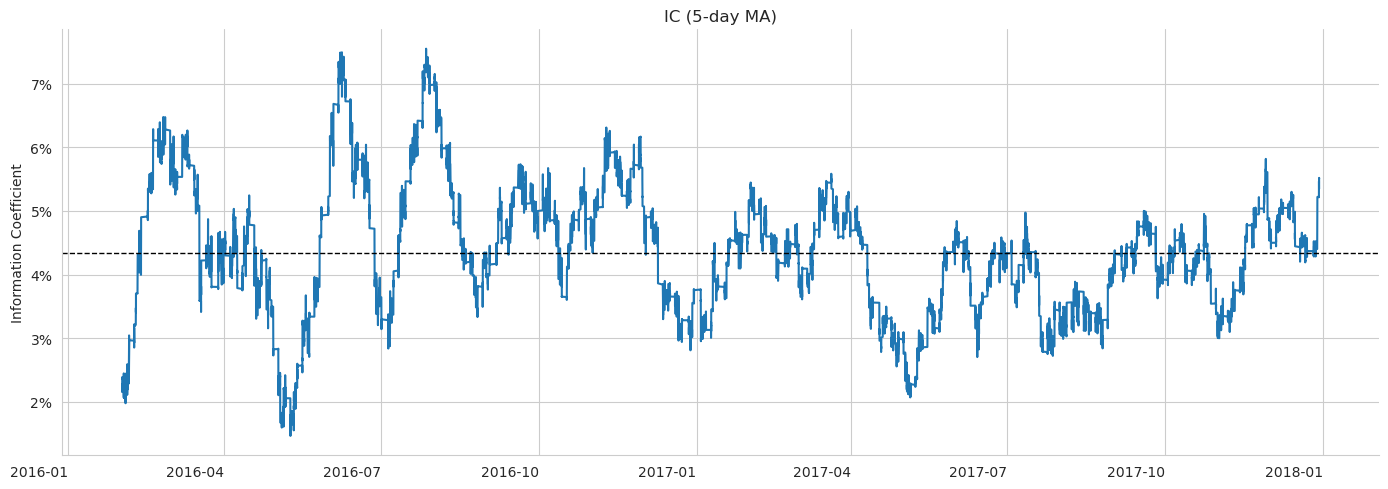

In [60]:
ax = ic_by_minute.rolling(5*650).mean().plot(figsize=(14, 5), title='IC (5-day MA)', rot=0)
ax.axhline(minute_ic_mean, ls='--', lw=1, c='k')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Information Coefficient')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Vectorized backtest of a naive strategey: financial performance by signal quantile

Alphalens does not work with minute-data, so we need to compute our own signal performance measures.

Unfortunately, Zipline's Pipeline also doesn't work for minute-data and Backtrader takes a very long time with such a large dataset. Hence, instead of an event-driven backtest of entry/exit rules as in previous examples, we can only create a rough sketch of the financial performance of a naive trading strategy driven by the model's predictions using vectorized backtesting (see Chapter 8 on the [ML4T workflow](../08_ml4t_workflow'). As we will see below, this does not produce particularly helpful results.

This naive strategy invests in equal-weighted portfolios of the stocks in each decile under the following assumptions (mentioned at the beginning of this notebook: 
1. Based on the predictions using inputs from the current and previous bars, we can enter positions at the first trade price in the following minute bar
2. We exit all positions at the last price in that following minute bar
3. There are no trading cost or market impact (slippage) of our trades (but we can check how sensitive the results would be).

#### Average returns by minute bar and signal quantile 

To this end, we compute the quintiles and deciles of the model's `fwd1min` predictions for each minute:

In [61]:
# To make quantiles need enough different pred values in order to bin them.

In [62]:
nv = cv_predictions["pred"].groupby('date_time').nunique()
nv

date_time
2016-01-04 09:30:00    28
2016-01-04 09:31:00    31
2016-01-04 09:32:00    27
2016-01-04 09:33:00    20
2016-01-04 09:34:00    18
                       ..
2017-12-29 12:15:00    93
2017-12-29 12:16:00    95
2017-12-29 12:17:00    93
2017-12-29 12:18:00    94
2017-12-29 12:19:00    94
Name: pred, Length: 84601, dtype: int64

In [63]:
nv.info(show_counts=True)

<class 'pandas.core.series.Series'>
DatetimeIndex: 84601 entries, 2016-01-04 09:30:00 to 2017-12-29 12:19:00
Series name: pred
Non-Null Count  Dtype
--------------  -----
84601 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


In [64]:
# We don't use minutes where there are not at least 90 different (90% of the tickers) predictions. 
# When the number of different predictions is low then confidence is low.  This appears to usually be during falling markets (but that hasn't been fully confirmed).

In [65]:
cvn_predictions = cv_predictions[time_stamp.isin(nv[nv > 90].index)]
cvn_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2349516 entries, 2016-05-02 09:30:00 to 2017-12-29 12:19:00
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   fwdwin    2349516 non-null  float64
 1   pred      2349516 non-null  float64
 2   stock_id  2349516 non-null  int64  
 3   ticker    2349516 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 89.6+ MB


In [66]:
# incomplete_minutesv = nv[nv <= 90].index
# # incomplete_minutesv = nv <= 90
# incomplete_minutesv
cvn_predictions.index

DatetimeIndex(['2016-05-02 09:30:00', '2016-05-02 09:30:00',
               '2016-05-02 09:30:00', '2016-05-02 09:30:00',
               '2016-05-02 09:30:00', '2016-05-02 09:30:00',
               '2016-05-02 09:30:00', '2016-05-02 09:30:00',
               '2016-05-02 09:30:00', '2016-05-02 09:30:00',
               ...
               '2017-12-29 12:19:00', '2017-12-29 12:19:00',
               '2017-12-29 12:19:00', '2017-12-29 12:19:00',
               '2017-12-29 12:19:00', '2017-12-29 12:19:00',
               '2017-12-29 12:19:00', '2017-12-29 12:19:00',
               '2017-12-29 12:19:00', '2017-12-29 12:19:00'],
              dtype='datetime64[ns]', name='date_time', length=2349516, freq=None)

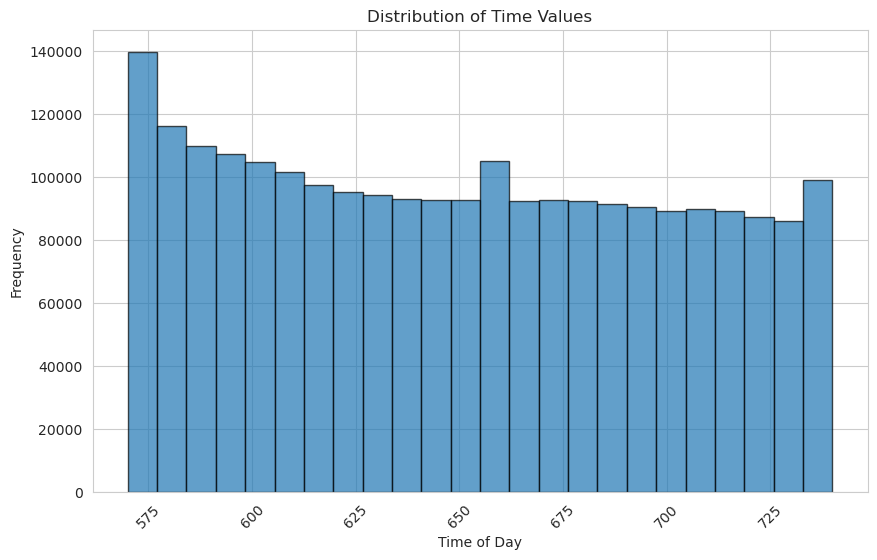

In [67]:
time_values = (cvn_predictions.index.hour * 60) + cvn_predictions.index.minute

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(time_values, bins=24, edgecolor='k', alpha=0.7)
plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Time Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [68]:
cvn_predictions.index.min(), cvn_predictions.index.max()

(Timestamp('2016-05-02 09:30:00'), Timestamp('2017-12-29 12:19:00'))

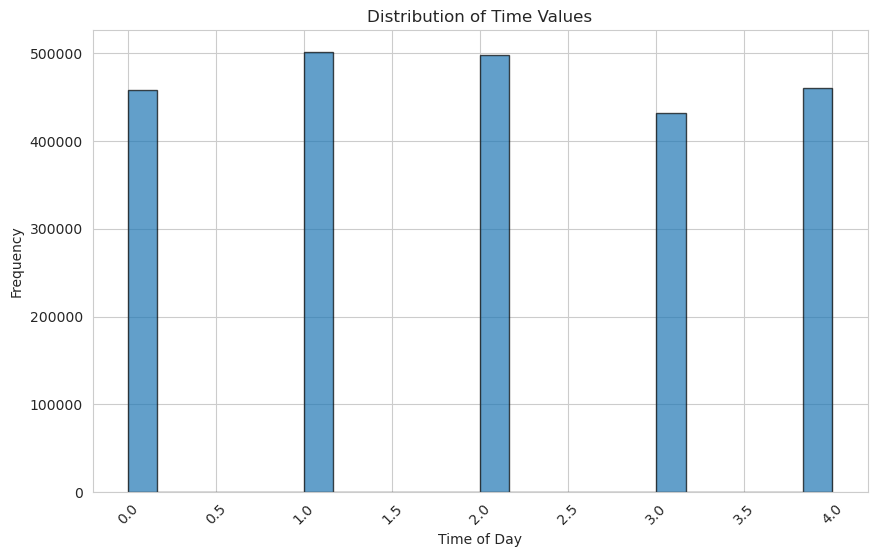

In [69]:
# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(cvn_predictions.index.day_of_week, bins=24, edgecolor='k', alpha=0.7)
plt.xlabel('Time of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Time Values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [70]:
print(f'{len(cvn_predictions.index)} ({len(cvn_predictions.index)/len(cv_predictions.index):.2%})')

2349516 (26.71%)


In [71]:
cvn_predictions

,fwdwin,pred,stock_id,ticker
date_time,,,,
2016-05-02 09:30:00,-0.005130,0.000596,0,AAL
2016-05-02 09:30:00,-0.010901,0.000440,1,AAPL
2016-05-02 09:30:00,0.010598,0.000329,2,ADBE
2016-05-02 09:30:00,0.003037,0.000270,3,ADI
2016-05-02 09:30:00,0.005424,0.000551,4,ADP
...,...,...,...,...
2017-12-29 12:19:00,-0.000146,0.000195,135,WDAY
2017-12-29 12:19:00,-0.000501,0.000208,136,WDC
2017-12-29 12:19:00,-0.001365,0.000221,138,WYNN


In [72]:
cv_predictions

,fwdwin,pred,stock_id,ticker
date_time,,,,
2016-01-04 09:30:00,0.003190,0.000588,0,AAL
2016-01-04 09:30:00,0.012738,0.000588,1,AAPL
2016-01-04 09:30:00,0.003063,0.000554,2,ADBE
2016-01-04 09:30:00,0.007621,0.000519,3,ADI
2016-01-04 09:30:00,0.001815,0.000424,4,ADP
...,...,...,...,...
2017-12-29 12:19:00,-0.000146,0.000195,135,WDAY
2017-12-29 12:19:00,-0.000501,0.000208,136,WDC
2017-12-29 12:19:00,-0.001365,0.000221,138,WYNN


In [73]:
# cv_predictions = cvn_predictions

In [74]:
cvn_minutes = cvn_predictions.index.get_level_values('date_time')
cvn_by_minute = cvn_predictions.groupby(cvn_minutes, group_keys=False)

In [75]:
# There shouldn't be any rows with less than 90 different predictions because we filtered them out above.

In [76]:
nunique_by_minute = cvn_predictions['pred'].groupby(cvn_minutes, group_keys=False).nunique()
nunique_by_minute[nunique_by_minute <= 90]

Series([], Name: pred, dtype: int64)

In [77]:
labels = list(range(1, 6))
labels

[1, 2, 3, 4, 5]

In [78]:
labels = list(range(1, 6))
cvn_predictions['quintile'] = cvn_by_minute.apply(lambda x: pd.qcut(x.pred, q=len(labels), precision=np.inf, labels=labels))

In [79]:
labels = list(range(1, 11))
cvn_predictions['decile'] = cvn_by_minute.apply(lambda x: pd.qcut(x.pred, q=len(labels), precision=np.inf, labels=labels).astype(int))

In [80]:
percentiles = [0.98, 1]
cvn_predictions['percentile'] = cvn_by_minute.apply(lambda x: pd.qcut(x.pred, q=percentiles, precision=np.inf, labels=percentiles[:-1]))

In [81]:
cvn_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2349516 entries, 2016-05-02 09:30:00 to 2017-12-29 12:19:00
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   fwdwin      2349516 non-null  float64 
 1   pred        2349516 non-null  float64 
 2   stock_id    2349516 non-null  int64   
 3   ticker      2349516 non-null  object  
 4   quintile    2349516 non-null  category
 5   decile      2349516 non-null  int64   
 6   percentile  67314 non-null    category
dtypes: category(2), float64(2), int64(2), object(1)
memory usage: 112.0+ MB


In [82]:
cvn_predictions

,fwdwin,pred,stock_id,ticker,quintile,decile,percentile
date_time,,,,,,,
2016-05-02 09:30:00,-0.005130,0.000596,0,AAL,5,9,NaN
2016-05-02 09:30:00,-0.010901,0.000440,1,AAPL,3,5,NaN
2016-05-02 09:30:00,0.010598,0.000329,2,ADBE,1,2,NaN
2016-05-02 09:30:00,0.003037,0.000270,3,ADI,1,1,NaN
2016-05-02 09:30:00,0.005424,0.000551,4,ADP,4,8,NaN
...,...,...,...,...,...,...,...
2017-12-29 12:19:00,-0.000146,0.000195,135,WDAY,3,6,NaN
2017-12-29 12:19:00,-0.000501,0.000208,136,WDC,4,7,NaN
2017-12-29 12:19:00,-0.001365,0.000221,138,WYNN,4,8,NaN


#### Descriptive statistics of intraday returns by quintile and decile of model predictions

Next, we compute the average one-minute returns for each quintile / decile and minute.

In [83]:
def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
    by_quantile = predictions.reset_index().groupby(['date_time', quantile])
    return by_quantile.fwdwin.mean().unstack(quantile).sort_index()

In [84]:
intraday_returns = {'quintile': compute_intraday_returns_by_quantile(cvn_predictions),
                    'decile': compute_intraday_returns_by_quantile(cvn_predictions, quantile='decile'),
                    'percentile': compute_intraday_returns_by_quantile(cvn_predictions, quantile='percentile'),
                   }

In [85]:
def summarize_intraday_returns(returns):
    summary = returns.describe(deciles)
    return pd.concat([summary.iloc[:1].applymap(lambda x: f'{x:,.0f}'),
                      summary.iloc[1:].applymap(lambda x: f'{x:.4%}')])

The returns per minute, averaged over the 23-months period, increase by quintile/decile and range from -.3 (-.4) to .27 (.37) basis points for the bottom and top quintile (decile), respectively. While this aligns with the finding of a weakly positive rank correlation coefficient, it also suggests that such small gains are unlikely to survive the impact of trading costs.

In [86]:
summary = summarize_intraday_returns(intraday_returns['quintile'])
summary

quintile,1,2,3,4,5
count,"22,577","22,577","22,577","22,577","22,577"
mean,0.0219%,0.0267%,0.0306%,0.0369%,0.0534%
std,0.1080%,0.1149%,0.1260%,0.1445%,0.1850%
min,-1.4028%,-1.0419%,-1.0643%,-1.2756%,-1.2237%
10%,-0.0909%,-0.0961%,-0.1075%,-0.1215%,-0.1476%
20%,-0.0430%,-0.0454%,-0.0505%,-0.0569%,-0.0700%
30%,-0.0164%,-0.0166%,-0.0173%,-0.0192%,-0.0230%
40%,0.0038%,0.0059%,0.0075%,0.0095%,0.0138%
50%,0.0224%,0.0261%,0.0311%,0.0358%,0.0486%
60%,0.0404%,0.0472%,0.0533%,0.0633%,0.0840%


In [87]:
summary = summarize_intraday_returns(intraday_returns['decile'])
summary

decile,1,2,3,4,5,6,7,8,9,10
count,"22,577","22,577","22,577","22,577","22,577","22,577","22,577","22,577","22,577","22,577"
mean,0.0212%,0.0225%,0.0256%,0.0279%,0.0287%,0.0325%,0.0360%,0.0378%,0.0440%,0.0621%
std,0.1179%,0.1164%,0.1215%,0.1271%,0.1336%,0.1414%,0.1510%,0.1654%,0.1821%,0.2264%
min,-1.8543%,-1.4156%,-0.9885%,-1.1207%,-0.9989%,-1.1363%,-1.2330%,-1.3194%,-1.4208%,-1.4131%
10%,-0.0999%,-0.1030%,-0.1046%,-0.1097%,-0.1169%,-0.1240%,-0.1295%,-0.1443%,-0.1574%,-0.1848%
20%,-0.0486%,-0.0511%,-0.0525%,-0.0546%,-0.0581%,-0.0606%,-0.0633%,-0.0730%,-0.0800%,-0.0920%
30%,-0.0206%,-0.0215%,-0.0215%,-0.0220%,-0.0236%,-0.0247%,-0.0247%,-0.0298%,-0.0319%,-0.0342%
40%,0.0018%,0.0018%,0.0028%,0.0046%,0.0047%,0.0053%,0.0057%,0.0058%,0.0064%,0.0111%
50%,0.0212%,0.0229%,0.0252%,0.0275%,0.0288%,0.0326%,0.0341%,0.0371%,0.0421%,0.0547%
60%,0.0408%,0.0437%,0.0478%,0.0506%,0.0528%,0.0594%,0.0634%,0.0685%,0.0771%,0.0984%


In [88]:
summary = summarize_intraday_returns(intraday_returns['percentile'])
summary

percentile,0.98
count,"22,577"
mean,0.0775%
std,0.3707%
min,-2.1898%
10%,-0.3279%
20%,-0.1728%
30%,-0.0768%
40%,0.0006%
50%,0.0692%
60%,0.1382%


In [89]:
intraday_returns['percentile'].max()

percentile
0.98    0.035604
dtype: float64

In [90]:
dfir = intraday_returns['percentile']
dfir

percentile,0.98
date_time,
2016-05-02 09:30:00,-0.009549
2016-05-02 09:31:00,0.004044
2016-05-02 09:32:00,-0.006092
2016-05-02 09:33:00,-0.008001
2016-05-02 09:34:00,-0.012887
...,...
2017-12-29 12:15:00,0.000464
2017-12-29 12:16:00,0.001549
2017-12-29 12:17:00,0.001902


In [91]:
dfir.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22577 entries, 2016-05-02 09:30:00 to 2017-12-29 12:19:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.98    22577 non-null  float64
dtypes: float64(1)
memory usage: 352.8 KB


In [92]:
dfir.columns.categories

Index([0.98], dtype='float64')

#### Cumulative Performance by Quantile

To simulate the performance of our naive strategy that trades all available stocks every minute, we simply assume that we can reinvest (including potential gains/losses) every minute. To check for the sensitivity with respect for trading cost, we can assume they are a constant number (fraction) of basis points, and subtract this number from the minute-bar returns.

In [93]:
def plot_cumulative_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwdwin', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwdwin').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

Without trading costs, the compounding of even fairly small gains leads to extremely large cumulative profits for the top quantile. However, these disappear as soon as we allow for minuscule trading costs that reduce the average quantile return close to zero.

##### Without trading costs

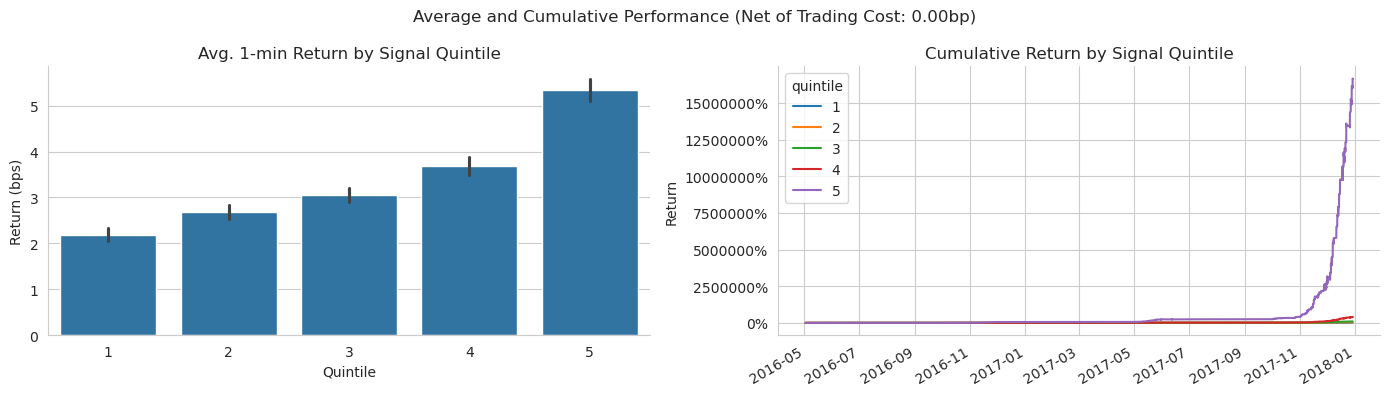

In [94]:
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=0)

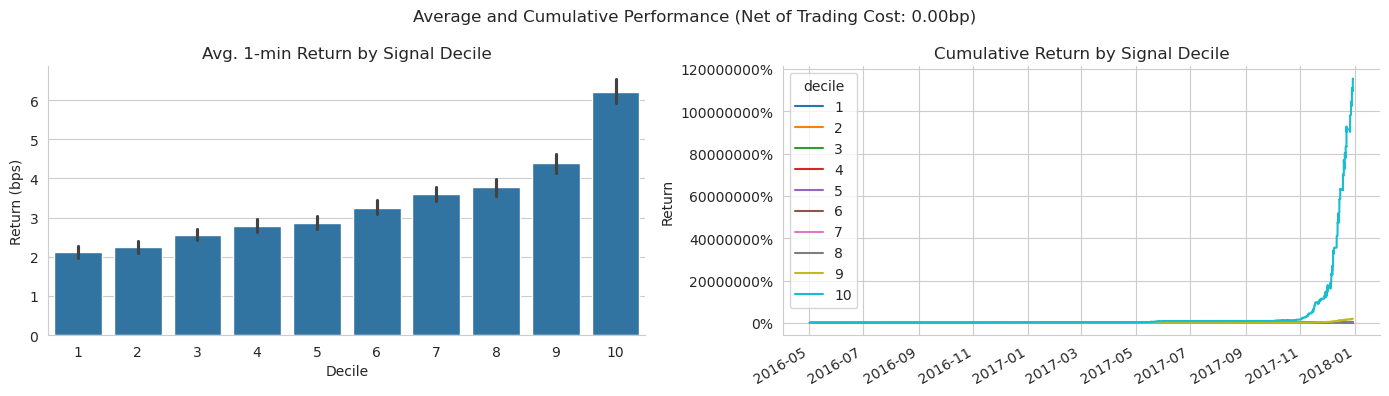

In [95]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=0)

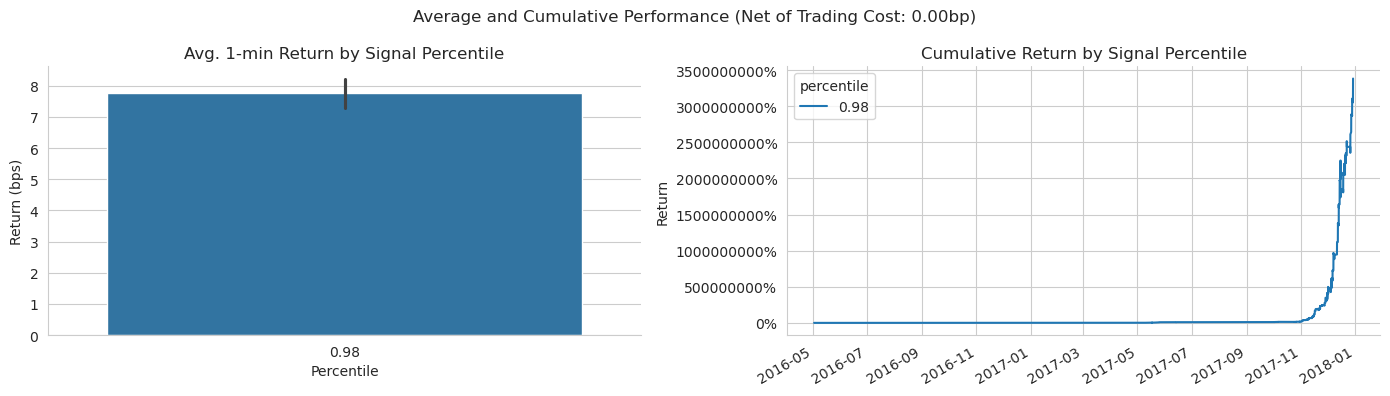

In [96]:
plot_cumulative_performance(intraday_returns, 'percentile', trading_costs_bp=0)

##### With extremely low trading costs

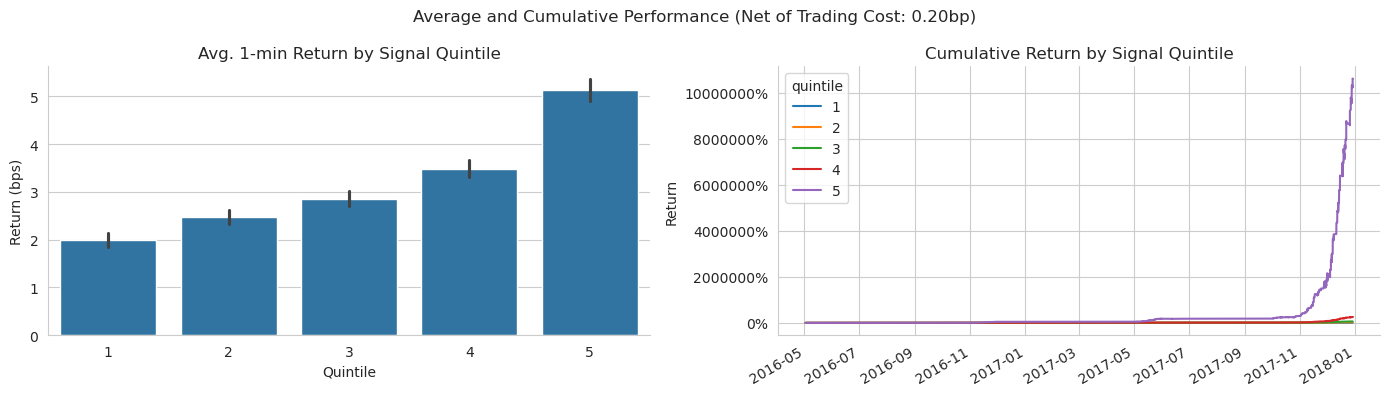

In [97]:
# assuming costs of a fraction of a basis point, close to the average return of the top quantile
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=.2)

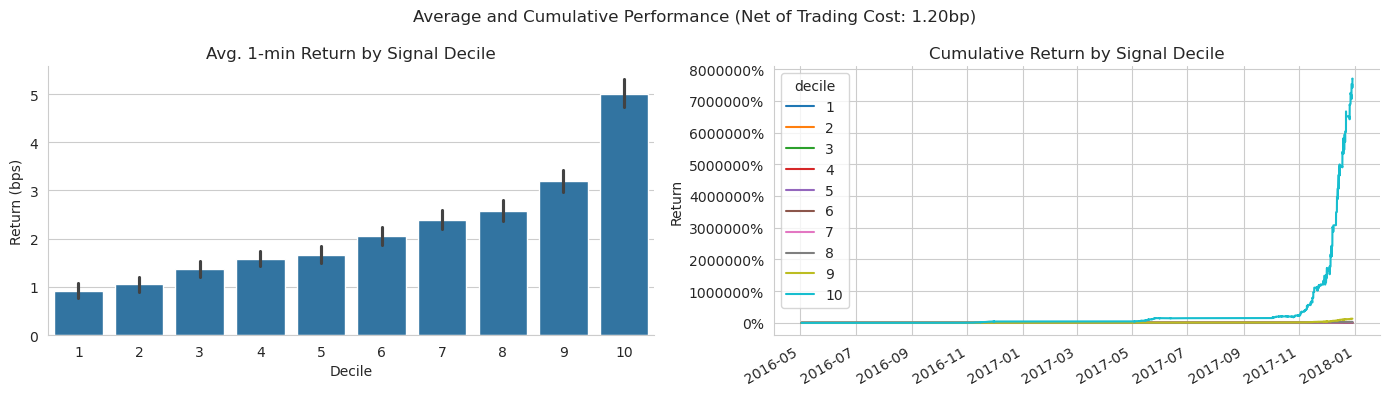

In [98]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=1.2)

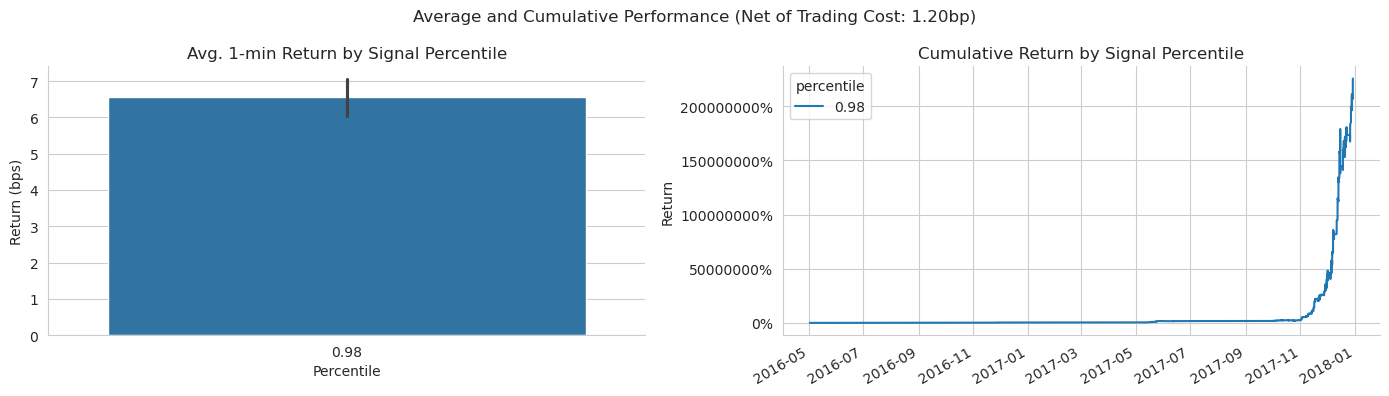

In [99]:
plot_cumulative_performance(intraday_returns, 'percentile', trading_costs_bp=1.2)

### Accumulated (Not Compounded) Returns

In [100]:
def plot_accumulated_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwdwin', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwdwin').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

### Feature Importance

We'll take a quick look at the features that most contributed to improving the IC across the 23 folds:

In [101]:
with pd.HDFStore(result_store) as store:
    fi_keys = [k[1:] for k in store.keys() if k[1:].startswith('fi')]
    fi = pd.concat([store[k].to_frame(i) for i, k in enumerate(fi_keys, 1)], axis=1)

The top features from a conventional feature importance perspective are the ticker, followed by NATR, minute of the day, latest 1m return and the CCI:

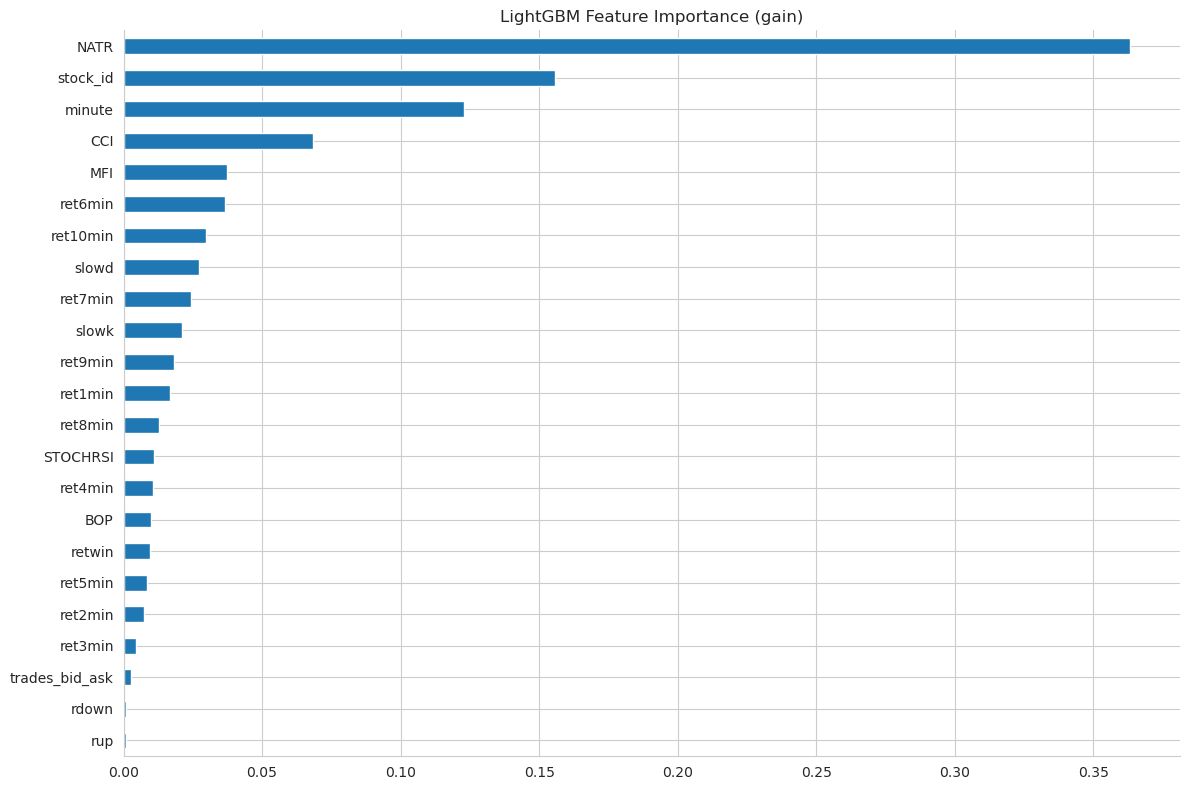

In [102]:
fi.mean(1).nsmallest(25).plot.barh(figsize=(12, 8), title='LightGBM Feature Importance (gain)')
sns.despine()
plt.tight_layout();

Explore with greater accuracy and in more detail how feature values affect predictions using SHAP values as demonstrated in various other notebooks in this Chapter and the appendix!

## Conclusion

We have seen that a relatively simple gradient boosting model is able to achieve fairly consistent predictive performance that is significantly better than a random guess even on a very short horizon. 

However, the resulting economic gains of our naive strategy of frequently buying/(short-)selling the top/bottome quantiles are too small to overcome the inevitable transaction costs. On the one hand, this demonstrates the challenges of extracting value from a predictive signal. On the other hand, it shows that we need a more sophisticated backtesting platform so that we can even begin to design and evaluate a more sophisticated strategy that requires far fewer trades to exploit the signal in our ML predictions. 

In addition, we would also want to work on improving the model by adding more informative feature, e.g. based on the quote/trade info contained in the Algoseek data, or by fine-tuning our model architecture and hyperparameter settings.

In [103]:
all_cv_predictions = cv_predictions

In [104]:
cv_predictions = all_cv_predictions
# cv_predictions = all_cv_predictions[0:20000]
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(by=minutes, sort=False)

In [105]:
by_minute.apply(lambda g: g.index.unique())

date_time
2016-01-04 09:30:00    DatetimeIndex(['2016-01-04 09:30:00'], dtype='...
2016-01-04 09:31:00    DatetimeIndex(['2016-01-04 09:31:00'], dtype='...
2016-01-04 09:32:00    DatetimeIndex(['2016-01-04 09:32:00'], dtype='...
2016-01-04 09:33:00    DatetimeIndex(['2016-01-04 09:33:00'], dtype='...
2016-01-04 09:34:00    DatetimeIndex(['2016-01-04 09:34:00'], dtype='...
                                             ...                        
2017-12-29 12:15:00    DatetimeIndex(['2017-12-29 12:15:00'], dtype='...
2017-12-29 12:16:00    DatetimeIndex(['2017-12-29 12:16:00'], dtype='...
2017-12-29 12:17:00    DatetimeIndex(['2017-12-29 12:17:00'], dtype='...
2017-12-29 12:18:00    DatetimeIndex(['2017-12-29 12:18:00'], dtype='...
2017-12-29 12:19:00    DatetimeIndex(['2017-12-29 12:19:00'], dtype='...
Length: 84601, dtype: object

In [106]:
def foo(g):
    return g.index.unique()

by_minute.apply(foo)

date_time
2016-01-04 09:30:00    DatetimeIndex(['2016-01-04 09:30:00'], dtype='...
2016-01-04 09:31:00    DatetimeIndex(['2016-01-04 09:31:00'], dtype='...
2016-01-04 09:32:00    DatetimeIndex(['2016-01-04 09:32:00'], dtype='...
2016-01-04 09:33:00    DatetimeIndex(['2016-01-04 09:33:00'], dtype='...
2016-01-04 09:34:00    DatetimeIndex(['2016-01-04 09:34:00'], dtype='...
                                             ...                        
2017-12-29 12:15:00    DatetimeIndex(['2017-12-29 12:15:00'], dtype='...
2017-12-29 12:16:00    DatetimeIndex(['2017-12-29 12:16:00'], dtype='...
2017-12-29 12:17:00    DatetimeIndex(['2017-12-29 12:17:00'], dtype='...
2017-12-29 12:18:00    DatetimeIndex(['2017-12-29 12:18:00'], dtype='...
2017-12-29 12:19:00    DatetimeIndex(['2017-12-29 12:19:00'], dtype='...
Length: 84601, dtype: object

In [107]:
minutes_df = minutes.to_frame()
minutes_df['date'] = minutes.date
minutes_df['time'] = minutes.time
minutes_df

,date_time,date,time
date_time,,,
2016-01-04 09:30:00,2016-01-04 09:30:00,2016-01-04,09:30:00
2016-01-04 09:30:00,2016-01-04 09:30:00,2016-01-04,09:30:00
2016-01-04 09:30:00,2016-01-04 09:30:00,2016-01-04,09:30:00
2016-01-04 09:30:00,2016-01-04 09:30:00,2016-01-04,09:30:00
2016-01-04 09:30:00,2016-01-04 09:30:00,2016-01-04,09:30:00
...,...,...,...
2017-12-29 12:19:00,2017-12-29 12:19:00,2017-12-29,12:19:00
2017-12-29 12:19:00,2017-12-29 12:19:00,2017-12-29,12:19:00
2017-12-29 12:19:00,2017-12-29 12:19:00,2017-12-29,12:19:00


In [108]:
end_of_day_time = minutes.time.max()
end_of_day_time

datetime.time(12, 20)

In [109]:
top_preds = by_minute['pred'].idxmax()
top_preds

date_time
2016-01-04 09:30:00   2016-01-04 09:30:00
2016-01-04 09:31:00   2016-01-04 09:31:00
2016-01-04 09:32:00   2016-01-04 09:32:00
2016-01-04 09:33:00   2016-01-04 09:33:00
2016-01-04 09:34:00   2016-01-04 09:34:00
                              ...        
2017-12-29 12:15:00   2017-12-29 12:15:00
2017-12-29 12:16:00   2017-12-29 12:16:00
2017-12-29 12:17:00   2017-12-29 12:17:00
2017-12-29 12:18:00   2017-12-29 12:18:00
2017-12-29 12:19:00   2017-12-29 12:19:00
Name: pred, Length: 84601, dtype: datetime64[ns]

In [110]:
cv_predictions.loc[top_preds]

,fwdwin,pred,stock_id,ticker
date_time,,,,
2016-01-04 09:30:00,0.003190,0.000588,0,AAL
2016-01-04 09:30:00,0.012738,0.000588,1,AAPL
2016-01-04 09:30:00,0.003063,0.000554,2,ADBE
2016-01-04 09:30:00,0.007621,0.000519,3,ADI
2016-01-04 09:30:00,0.001815,0.000424,4,ADP
...,...,...,...,...
2017-12-29 12:19:00,-0.000146,0.000195,135,WDAY
2017-12-29 12:19:00,-0.000501,0.000208,136,WDC
2017-12-29 12:19:00,-0.001365,0.000221,138,WYNN


In [111]:
group_count = 0

def print_group(group):
    global group_count
    # print(f"{group['pred'].nunique()=}")
    if group['pred'].nunique() > 70:
        group_count += 1
        if group_count <= 10:
            # print(f"{group=}")
            # print(f"{group.index=}")
            print(f"{group.index.min()=}")
            print(f"{group.index.unique()=}")
            # print(f"{group['pred'].idxmax()=}")
            # print(f"{type(group)=}")
            group.info()
            print(f"{group['pred'].max()=}")
            # print(f"{group.loc[group['pred'].idxmax()]=}")
            # print(f"{type(group['pred'])=}")
            # print(f"{group['pred']=}")
            print(f"{group['pred'].argmax()=}")
            # print(f"{ticker_to_id[group['pred'].argmax()]=}")
            print(f"{group.iloc[group['pred'].argmax()]=}")
            # print(f"{group.sort(['pred']).last()=}")

by_minute.apply(print_group, include_groups=False)

group.index.min()=Timestamp('2016-03-01 09:30:00')
group.index.unique()=DatetimeIndex(['2016-03-01 09:30:00'], dtype='datetime64[ns]', name='date_time', freq=None)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2016-03-01 09:30:00 to 2016-03-01 09:30:00
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fwdwin    103 non-null    float64
 1   pred      103 non-null    float64
 2   stock_id  103 non-null    int64  
 3   ticker    103 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 8.1+ KB
group['pred'].max()=0.00384642229413261
group['pred'].argmax()=35
group.iloc[group['pred'].argmax()]=fwdwin     -0.040607
pred        0.003846
stock_id          47
ticker          ENDP
Name: 2016-03-01 09:30:00, dtype: object
group.index.min()=Timestamp('2016-03-01 09:34:00')
group.index.unique()=DatetimeIndex(['2016-03-01 09:34:00'], dtype='datetime64[ns]', name='date_time', freq=None)
<class 'p

""


In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13452358 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 12:20:00'))
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   minute          int64  
 1   ret1min         float64
 2   ret2min         float64
 3   ret3min         float64
 4   ret4min         float64
 5   ret5min         float64
 6   ret6min         float64
 7   ret7min         float64
 8   ret8min         float64
 9   ret9min         float64
 10  ret10min        float64
 11  retwin          float64
 12  fwdwin          float64
 13  rup             float64
 14  rdown           float64
 15  BOP             float64
 16  CCI             float64
 17  MFI             float64
 18  STOCHRSI        float64
 19  slowd           float64
 20  slowk           float64
 21  NATR            float64
 22  trades_bid_ask  float64
 23  stock_id        int64  
dtypes: float64(22), int64(2)
memory usage: 2.5+ GB


In [113]:
def best_stock_prediction(group):
    return group.iloc[group['pred'].argmax()]

best_prediction_per_minute = by_minute.apply(best_stock_prediction)
best_prediction_per_minute

,fwdwin,pred,stock_id,ticker
date_time,,,,
2016-01-04 09:30:00,0.006298,0.005026,121,SYMC
2016-01-04 09:31:00,-0.004972,0.005026,72,JD
2016-01-04 09:32:00,0.000452,0.003999,36,CTRP
2016-01-04 09:33:00,-0.010532,0.003278,14,ATVI
2016-01-04 09:34:00,-0.007639,0.003278,19,BIDU
...,...,...,...,...
2017-12-29 12:15:00,0.003724,0.000389,114,SIRI
2017-12-29 12:16:00,-0.000772,0.000391,89,MELI
2017-12-29 12:17:00,0.003724,0.000357,114,SIRI


In [114]:
os.environ["PROJECTS_DIR"] = "/home/jovyan/work/"

In [115]:
workspace_path = Path(os.environ.get("PROJECTS_DIR"), "machine-learning-for-trading")
nasdaq_path = workspace_path / 'data/nasdaq100'
algoseek_path = nasdaq_path / 'algoseek-longer.h5'

In [116]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']
# This is in PyPi tables
with pd.HDFStore(algoseek_path) as store:
    algoseek_df = store['min_taq'].loc[:, data_cols].sort_index()
algoseek_df.index.rename(['ticker', 'date_time'], inplace=True)
algoseek_df

first   high    low     last     price  volume  \
ticker date_time                                                              
AAL    2015-01-02 09:30:00  54.230  54.60  54.16  54.4600  54.29077  322952   
       2015-01-02 09:31:00  54.460  54.53  54.03  54.0300  54.25423   41021   
       2015-01-02 09:32:00  54.030  54.38  54.03  54.3300  54.21918   38838   
       2015-01-02 09:33:00  54.350  54.37  54.02  54.0200  54.17345   28495   
       2015-01-02 09:34:00  54.030  54.47  54.03  54.4500  54.25115   33939   
...                            ...    ...    ...      ...       ...     ...   
YHOO   2017-06-16 12:26:00  52.270  52.28  52.27  52.2800  52.27499   44661   
       2017-06-16 12:27:00  52.280  52.28  52.27  52.2700  52.27085   28929   
       2017-06-16 12:28:00  52.275  52.30  52.27  52.2950  52.28527  101998   
       2017-06-16 12:29:00  52.291  52.30  52.25  52.2500  52.27528   50636   
       2017-06-16 12:30:00  52.245  52.25  52.23  52.2389  52.23807   33697   

                               up    down     rup  rdown   atask   atbid  
ticker date_time                                                          
AAL    2015-01-02 09:30:00  38994  212658  103880  28552  121743  219484  
       2015-01-02 09:31:00  21769   26602   11350  24854   13539   35267  
       2015-01-02 09:32:00  23979   18662   26748   9663   34225   15960  
       2015-01-02 09:33:00  14918   20112    7143  14687    6819   17940  
       2015-01-02 09:34:00  13292    7437   29723   3664   30543    9307  
...                           ...     ...     ...    ...     ...     ...  
YHOO   2017-06-16 12:26:00   6505    5967   20908  26378   24434   26578  
       2017-06-16 12:27:00   5480    6225    5023  30428    5800   32528  
       2017-06-16 12:28:00  31558    9850   77951  42382   74346   39753  
       2017-06-16 12:29:00   6424    5549    9334  48119   15782   43701  
       2017-06-16 12:30:00   4702    4716    8889  24991   11810   27352  

[14514933 rows x 12 columns]

In [117]:
algoseek_df.loc['JD']

,first,high,low,last,price,volume,up,down,rup,rdown,atask,atbid
date_time,,,,,,,,,,,,
2015-07-29 09:30:00,32.6600,32.9400,32.60,32.895,32.67687,45887,3152,35663,4199,7726,11663,3962
2015-07-29 09:31:00,32.8700,32.9700,32.82,32.905,32.92683,21262,10935,8981,13496,7658,17926,9109
2015-07-29 09:32:00,32.9000,33.0000,32.73,32.970,32.90049,61804,16650,12430,25709,22945,24420,31219
2015-07-29 09:33:00,32.9600,33.0000,32.75,32.790,32.88637,40882,16335,22604,6130,26703,8200,38482
2015-07-29 09:34:00,32.7700,32.9200,32.72,32.910,32.80036,23238,5080,6482,9810,8906,11750,10488
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29 12:26:00,41.5900,41.6001,41.59,41.600,41.59864,9102,3420,2447,7036,1386,6500,1766
2017-12-29 12:27:00,41.6000,41.6000,41.59,41.600,41.59706,1416,226,303,800,213,1001,516
2017-12-29 12:28:00,41.6000,41.6000,41.59,41.600,41.59911,9544,884,501,7660,852,6329,2201


In [118]:
positions = {}

all_trades = []

def open_position(ticker, pred_datetime, pred):
    global algoseek_df
    open_datetime = pred_datetime + pd.Timedelta(minutes=1)
    # position['open_datetime'] = open_datetime
    # position['open_price'] = data.loc[ticker, open_datetime]['price']
    # print(f"{algoseek_df.loc[ticker, open_datetime]=}")
    # print(f"{algoseek_df.loc[ticker, open_datetime]['price']=}")
    return {'ticker': ticker, 'open_datetime':open_datetime, 'open_price':algoseek_df.loc[ticker, open_datetime]['price'], 'pred':pred}
    
def close_position(position, pred_datetime):
    global algoseek_df
    global all_trades
    close_datetime = pred_datetime + pd.Timedelta(minutes=1)
    position['close_datetime'] = close_datetime
    # print(f"{algoseek_df.loc[position['ticker'], close_datetime]=}")
    position['close_price'] = algoseek_df.loc[position['ticker'], close_datetime]['price']
    position['gain'] = (position['close_price'] - position['open_price']) / position['open_price']
    all_trades.append(position)
    return position

def trading_strategy(group):
    global cv_predictions
    global positions

    c = 70
    k = 10
    mp = 0.000

    trades = []

    # group.info()
    # print(f"{group=}")

    # print(f"{group.index.unique()=}")
    this_datetime = group.index.unique().min()
    # print(f"{this_datetime=}")
    if this_datetime.time() >= end_of_day_time:
        for position in positions.values():
            trades.append(close_position(position, this_datetime))
        positions = {}
        return pd.DataFrame(trades)

    # top_pred = best_stock_prediction(group)
    top_preds = group.sort_values('pred', ascending=False).head(k)
    # top_ticker = top_pred['ticker']
    top_ticker = top_preds.iloc[0]['ticker']
    # print(f"{this_datetime=} {top_ticker=} {positions=}")
    # print(f"{ticker=}")
    # print(f"{group=}")
    # by_ticker = group.set_index('ticker')
    # by_ticker.info()
    # print(f"{top_preds=}")
    top_tickers = top_preds['ticker']
    for ticker, position in positions.copy().items():
        if not ticker in top_tickers:
            # print(f"{by_ticker.loc[ticker]=}")
            # try:
            #     ticker_pred = by_ticker.loc[ticker]
            #     print(f"{ticker_pred=}")
            #     if ticker_pred['pred'] < 0:
            #         trades.append(close_position(position, this_datetime))
            # except KeyError:
            #     print(f"missing {ticker=}")
            #     trades.append(close_position(position, this_datetime))
            trades.append(close_position(position, this_datetime))
            del positions[ticker]

    # print(f"{group['pred'].nunique()=}")
    if (not top_ticker in positions) and (group['pred'].nunique() > c) and (top_preds.iloc[0]['pred'] > mp):
        positions[top_ticker] = open_position(top_ticker, this_datetime, pred=top_preds.iloc[0]['pred'])
        
    if trades:
        return pd.DataFrame(trades)
    return None

trades = by_minute.apply(trading_strategy)
len(all_trades)

26153

In [119]:
pd.DataFrame(all_trades)['gain'].sum()

0.7191656494682555

In [120]:
df = pd.DataFrame(all_trades)
df['gain'].corr(df['pred'])

0.03047873268044784

In [121]:
df[['gain', 'pred']].corr()

,gain,pred
gain,1.000000,0.030479
pred,0.030479,1.000000


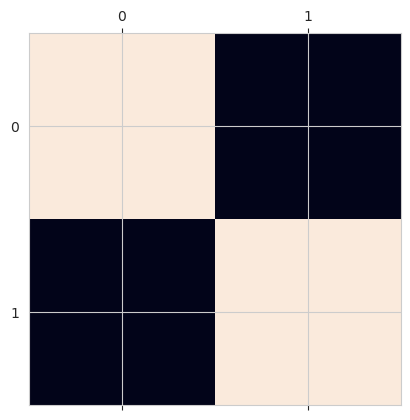

In [122]:
plt.matshow(df[['gain', 'pred']].corr())
plt.show()

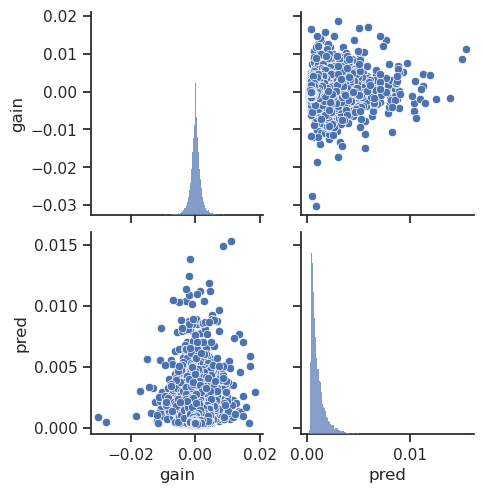

In [123]:
import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)    
g = sns.pairplot(df[['gain', 'pred']])
plt.show()

In [ ]:
all_trades